# **Deep Learning applied on Nairobi slum**

## Import libraries

In [1]:
import tensorflow as tf
import os, sys
import numpy as np
import h5py

In [2]:
import matplotlib.pyplot as plt

In [3]:
#from stackage import stackage

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
def import_hf5(data_path, data_name, get_name):
    hf = h5py.File(os.path.join(data_path, data_name), mode="r")
    data = hf.get(get_name)
    stack = np.array(data)
    hf.close()
    return stack

In [37]:
#code from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def normalise_01(image_data):
    stack = image_data
    image_data -= np.min(stack, axis=0)
    image_data /= (np.max(stack, axis=0) - np.min(stack, axis=0))
    return image_data

In [7]:
def standardise(image_data):
    image_data -= np.mean(image_data, axis=0, dtype=np.float32)
    image_data /= np.std(image_data, axis=0, dtype=np.float32)
    return image_data

In [8]:
def circle(train_lulc,test_lulc,title) :
    train_slum = (train_lulc==1).sum()
    train_noslum = (train_lulc==0).sum()
    test_slum = (test_lulc==1).sum()
    test_noslum = (test_lulc==0).sum()
    
    RESTRAIN = [train_slum,train_noslum]
    RESTEST = [test_slum,test_noslum]
    RESLABEL1 = ['Training slums', 'Training no slums' ]
    RESLABEL2 = ['Test slums', 'Test no slums']
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.pie(RESTRAIN, labels=RESLABEL1, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax2.pie(RESTEST, labels=RESLABEL2, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    
    plt.title(title)
    
    plt.show()

In [9]:
from osgeo import gdal
import numpy as np

#code inspired from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def stackage(list_raster):
    stack = []
    for patch in list_raster :
        pat = gdal.Open(patch)#.decode('ascii')
        data_rast = pat.ReadAsArray().astype(np.float32)
        data_rast = np.transpose(data_rast,(1,2,0))
        stack.append(data_rast)

    stack= np.array(stack)
    
    return stack


In [42]:
def assimilation(patch_id_train, patch_id_test, path_raster):
    train_path = []
    test_path = []

    patch_id_train_re = patch_id_train.reshape(1,patch_id_train.size)
    patch_id_train_list = patch_id_train_re.tolist()[0]
    patch_id_test_re = patch_id_test.reshape(1,patch_id_test.size)
    patch_id_test_list = patch_id_test_re.tolist()[0]

    for path in path_raster : #récupération des id des images
        image = path.split('/')[-1]
        image_id = int(image.split('_')[-2])
        if image_id in patch_id_train_list :
            index = patch_id_train_list.index(image_id)
            train_path.insert(index,path)
        elif image_id in patch_id_test_list :
            index = patch_id_test_list.index(image_id)
            test_path.insert(index,path)

    #stack = stackage(train_path)

    stack_train = stackage(train_path)
    #stack = stackage(test_path)
    stack_test = stackage(test_path)
    
    stack_train = standardise(stack_train)
    stack_test = standardise(stack_test)

    return stack_train, stack_test

In [11]:
def make_csv(predict, name):
    import csv

    predict = predict.reshape(1,predict.size).tolist()[0]

    header = ['prob_slum','id']
    cont = []
    cont.append(header)
    for x,y in zip(predict,patch_id_raster):
        current_row = [x,y]
        cont.append(current_row)

    cont

    with open(str(name)+'.csv','w') as file :
        write = csv.writer(file)
        write.writerows(cont)

## Importing data RGB

In [7]:
data_path = 'Images/big_raster/tr_RGBNIR_patch/'
data_name = "RGBNIR.hdf5"
path_raster = import_hf5(data_path,data_name,'raster')

patch_id_train = import_hf5(data_path,data_name,'id_train')
patch_id_test = import_hf5(data_path,data_name,'id_test')

patch_lulc_train = import_hf5(data_path,data_name,"lulc_train")
patch_lulc_test = import_hf5(data_path,data_name,"lulc_test")

patch_id = import_hf5(data_path,data_name,"patch_id")
patch_lulc = import_hf5(data_path,data_name,"patch_lulc")

In [8]:
print(patch_id_train.shape)

(5487, 1)


### Separate train patchs to test patchs

In [23]:
stack_train = assimilation(patch_id_train, patch_id_test)[0]
stack_test = assimilation(patch_id_train, patch_id_test)[1]

In [32]:
data_path = 'Images/big_raster/g_RGBNIR_patch/'
data_name = "grid.hdf5"
path_grid_raster = import_hf5(data_path,data_name,'raster')
patch_id_raster = import_hf5(data_path,data_name,'patch_id')

stack = stackage(path_grid_raster)
stack_grid = standardise(stack)

## Importing data SAR

In [11]:
data_path = 'Images/small_raster/tr_SAR_patch/'
data_name = "tr_SAR.hdf5"
path_sar = import_hf5(data_path,data_name,'raster')

print(path_sar)

sar_id_train = import_hf5(data_path,data_name,'id_train')
sar_id_test = import_hf5(data_path,data_name,'id_test')

sar_lulc_train = import_hf5(data_path,data_name,"lulc_train")
sar_lulc_test = import_hf5(data_path,data_name,"lulc_test")

sar_id = import_hf5(data_path,data_name,"patch_id")

train_path_sar = []
test_path_sar = []

sar_id_train_re = sar_id_train.reshape(1,patch_id_train.size)
sar_id_train_list = sar_id_train_re.tolist()[0]
sar_id_test_re = sar_id_test.reshape(1,patch_id_test.size)
sar_id_test_list = sar_id_test_re.tolist()[0]

for path in path_sar : #récupération des id des images
    image = path.split(b'/')[-1]
    image_id = int(image.split(b'_')[-2])
    if image_id in patch_id_train_list :
        index = sar_id_train_list.index(image_id)
        train_path_sar.insert(index,path)
    elif image_id in sar_id_test_list :
        index = sar_id_test_list.index(image_id)
        test_path_sar.insert(index,path)
        
stack = stackage(train_path_sar)
stack_sar_train = normalise_01(stack)
stack = stackage(test_path_sar)
stack_sar_test = normalise_01(stack)

[b'Images/small_raster/tr_SAR_patch/tr_SAR_52516_1.tif'
 b'Images/small_raster/tr_SAR_patch/tr_SAR_52534_1.tif'
 b'Images/small_raster/tr_SAR_patch/tr_SAR_52535_1.tif' ...
 b'Images/small_raster/tr_SAR_patch/tr_SAR_81073_0.tif'
 b'Images/small_raster/tr_SAR_patch/tr_SAR_81089_0.tif'
 b'Images/small_raster/tr_SAR_patch/tr_SAR_81118_0.tif']


In [12]:
print(stack_sar_test.shape)

(519, 10, 10, 3)


 ## Data circle graph

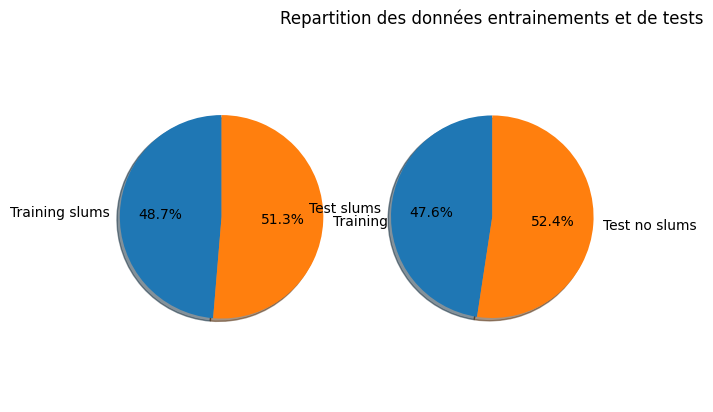

In [35]:
circle(patch_lulc_train,patch_lulc_test,'Repartition des données entrainements et de tests')

# **Starting deep learning**


## **Model based on the tutorial**

### Creating model

In [36]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('accuracy') > 0.90:
      print("\n Enough accuracy")
      self.model.stop_training = True
        
callbacks = myCallback()

In [40]:
def basic_model(x_train, y_train, x_test, y_test, stack_grid, epochs, batch, callbacks):
    
    from tensorflow.keras.optimizers import SGD, Adam
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
    datagen = ImageDataGenerator(
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='reflect'
    )
    data_augmentation = tf.keras.Sequential([
                        layers.RandomFlip("vertical"),
                        layers.RandomRotation(0.2, fill_mode='reflect'),
                        layers.RandomTranslation(height_factor=0.05, width_factor=0.05, fill_mode='reflect'),
                    ])

    # Data augmentation
    model.add(data_augmentation)
    
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(10, 10, 4)),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.2, name = 'fc1_drop', seed=3),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.summary()

    model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
    
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch), epochs=epochs, validation_data = (x_test,y_test), callbacks=[callbacks])
    
    model.evaluate(x_test,y_test)
    
    predict = model.predict(stack_grid)
    
    return history, predict

**Le modèle** : 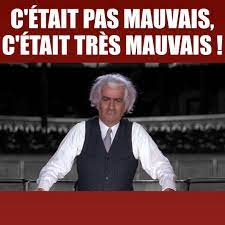

In [46]:
RD = []
HIST = []
PRED = []
for i in range(5) :
    rd = np.random.randint(1,500)
    RD.append(rd)
    patch_id_train, patch_id_test, patch_lulc_train, patch_lulc_test = train_test_split(patch_id,patch_lulc, test_size=0.2, random_state=rd)
    stack_train = assimilation(patch_id_train, patch_id_test)[0]
    stack_test = assimilation(patch_id_train, patch_id_test)[1]
    history, predict = basic_model(stack_train, patch_lulc_train, stack_test,patch_lulc_test, stack_grid, 100, 64, callbacks)
    HIST.append(history)
    PRED.append(predict)
    
print(RD)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 8, 8, 32)          1184      
                                                                 
 conv2d_15 (Conv2D)          (None, 6, 6, 64)          18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 3, 3, 64)         0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 576)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               295424    
                                                                 
 fc1_drop (Dropout)          (None, 512)               0         
                                                      

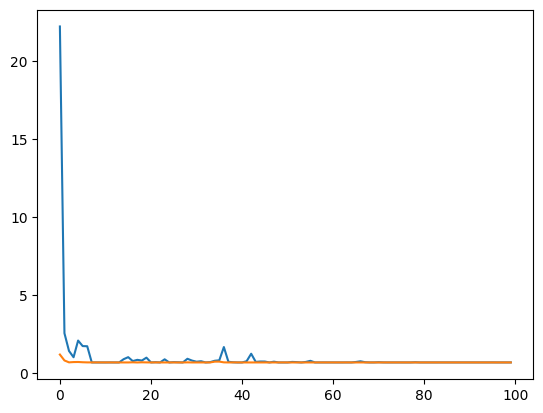

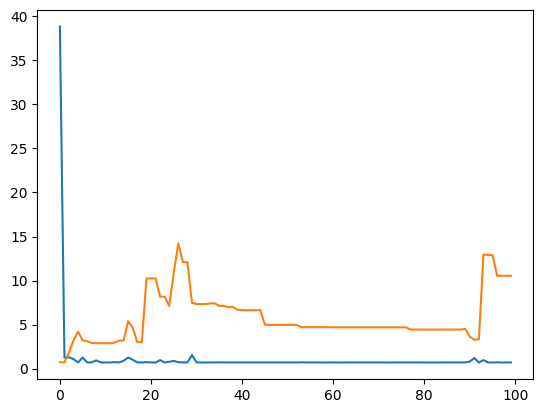

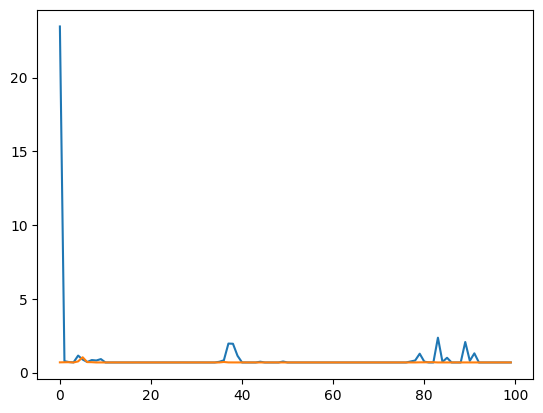

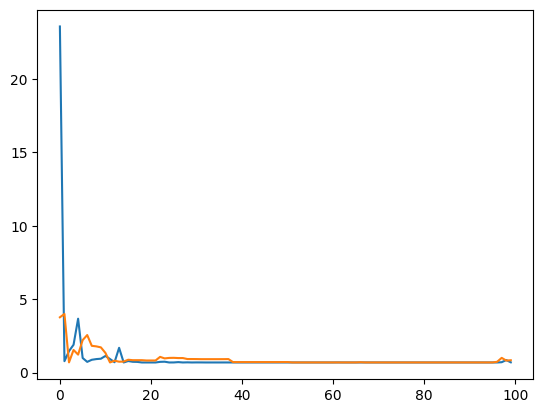

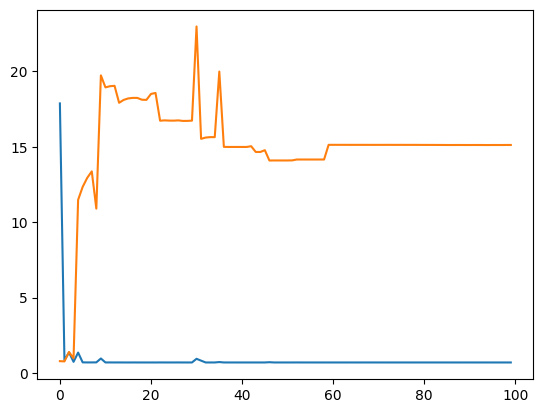

In [49]:
for history in HIST :
    plt.plot(history.history["loss"])
    plt.plot(history.history['val_loss'])
    plt.show()

In [50]:
predict = PRED[0]
print(predict)
make_csv(predict)

[[0.49820933]
 [0.4831725 ]
 [0.4896989 ]
 ...
 [0.5058764 ]
 [0.47808528]
 [0.488462  ]]


In [ ]:
plt.hist(predict)
plt.show()

## **VGG**

### Import libraries

In [12]:
import numpy as np
import os, sys
import pandas as pd
import glob
import re
from tensorflow import keras
import natsort
import sklearn
import tensorflow as tf
import datetime
import cv2
import shutil
import time
import tempfile
import h5py



from IPython.display import clear_output



import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted
from keras.utils import np_utils
from keras.constraints import max_norm
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [13]:
print(tf.__version__)

2.9.1


In [14]:
! nvidia-smi

Mon Jul 25 07:01:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:05:00.0  On |                  N/A |
|  0%   38C    P8    11W / 200W |    586MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
import random as python_random
SEED = 101
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()


In [16]:
# Add local module to the path
src = os.path.abspath('SRC/')
if src not in sys.path:
    sys.path.append(src)


In [17]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import functions for plots
from plots import plot_loss, plot_pred_test, plot_pred_train, plot_loss_multirun
# Import functions for metrics to monitoring accuracy
from metrics import coeff_determination
# Import functions for display
from display import Norma_Xpercentile
# Import functions for exportation of results
from export_results import save_predictions, write_run_metrics_file
# Import LRFinder function
from LRFinder import LRFinder

In [ ]:
# Random selection
plt.rcParams["figure.facecolor"] = 'w'
plt.figure(figsize=(15, 15))
for i in range(3):
    rd_img = np.random.randint(1,500)
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(Norma_Xpercentile(stack_test[rd_img,:,:,:]))
    plt.axis("off")
    plt.title("Random indx: %s\nID: %s\nlulc: %0.3f" %(rd_img,patch_id_train[rd_img],patch_lulc_train[rd_img]))
#plt.subplots_adjust(hspace=0.001)
plt.tight_layout() 

### Model construction

In [43]:
def vgg_model(x_train, y_train, x_test, y_test, stack_grid, epochs, batch, callbacks) :
    
    datagen = ImageDataGenerator(
                            vertical_flip=True,
                            rotation_range=20,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            fill_mode='reflect'
                            )


    model = Sequential()
    
    data_augmentation = tf.keras.Sequential([
                        layers.RandomFlip("vertical"),
                        layers.RandomRotation(0.2, fill_mode='reflect'),
                        layers.RandomTranslation(height_factor=0.05, width_factor=0.05, fill_mode='reflect'),
                    ])

    # Data augmentation
    model.add(data_augmentation)
    
    # Convolution block 1 
    model.add(Conv2D(64, (3, 3), padding='same', name='block1_conv1', input_shape=(10,10,9))) #block1_conv1
    model.add(BatchNormalization(axis=-1, name='block1_bn1'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='same', name='block1_conv2')) #block1_conv2 
    model.add(BatchNormalization(axis=-1, name='block1_bn2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block1_pool')) #block1_pool

    model.add(Flatten())
    model.add(Dense(256, name = 'fc1'))
    model.add(BatchNormalization(axis=-1, name = 'fc1_bn1'))
    model.add(Activation('relu'))
    model.add(Dropout(0.4, name = 'fc1_drop', seed=3)) 

    # Regression layer 
    model.add(Dense(1, activation = 'sigmoid'))   
    
    
    
     
    opt = Adam(learning_rate=1e-3)
    # Compile the model with LOSS, Optimizer, metrics
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=['mean_absolute_error','RootMeanSquaredError',coeff_determination,'accuracy'])              
    
    
    
    # Train the model 
    history = model.fit(datagen.flow(x_train, y_train, batch_size=batch, shuffle=False, seed=3),
                                validation_data = (x_test,y_test),
                                epochs = epochs, 
                                callbacks = [callbacks])
    
    model.summary()
    
    model.evaluate(x_test,y_test)
    
    predict = model.predict(stack_grid)
    
    return history, predict


### Results

In [21]:
from chunckage import chunckage

S1S2_patch_path, S1S2_patch_id, S1S2_patch_lulc = chunckage("Images/big_raster/","ALLS2S1",".tif",'Images/big_sample/','sample.gpkg','tr_ALLS2S1',1)



(238890.0, 288990.0, 9846480.0, 9871580.0)


In [22]:
S1S2_grid_path, S1S2_grid_id = chunckage("Images/big_raster/","ALLS2S1",".tif",'Images/big_grid/','grid.gpkg','g_ALLS2S1',0)




(238890.0, 289090.0, 9846380.0, 9871680.0)


In [41]:
stack = stackage(S1S2_grid_path)
stack_grid = standardise(stack)

In [35]:
print(max(stack_grid[:,0,0,7]))

1.0


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('accuracy') > 0.90:
      print("\n Enough accuracy")
      self.model.stop_training = True
        
callbacks = myCallback()



RD = []
HIST = []
PRED = []

for i in range(3) :
    
    rd = np.random.randint(1,1000)
    print(rd)
    
    
    patch_id_train, patch_id_test, patch_lulc_train, patch_lulc_test = train_test_split(S1S2_patch_id,S1S2_patch_lulc, test_size=0.2, random_state=rd)
    patch_id_train = np.array(patch_id_train)
    patch_id_train = patch_id_train.reshape(patch_id_train.size, -1)
    patch_id_test = np.array(patch_id_test)
    patch_id_test = patch_id_test.reshape(patch_id_test.size, -1)
    patch_lulc_train = np.array(patch_lulc_train)
    patch_lulc_train = patch_lulc_train.reshape(patch_lulc_train.size, -1)
    patch_lulc_test = np.array(patch_lulc_test)
    patch_lulc_test = patch_lulc_test.reshape(patch_lulc_test.size, -1)
    
    stack_train = assimilation(patch_id_train, patch_id_test, S1S2_patch_path)[0]
    stack_test = assimilation(patch_id_train, patch_id_test, S1S2_patch_path)[1]
    
    history, predict = vgg_model(stack_train, patch_lulc_train, stack_test,patch_lulc_test, stack_grid, 200, 64, callbacks)
    
    HIST.append(history)
    PRED.append(predict)
    




In [ ]:
for history in HIST :
    plt.plot(history.history["loss"])
    plt.plot(history.history['val_loss'])
    plt.show()

In [ ]:
for history in HIST :
    plt.plot(history.history["accuracy"])
    plt.plot(history.history['val_accuracy'])
    plt.show()

In [ ]:
for predict in PRED : 
    plt.hist(predict)
    plt.show()

In [130]:
make_csv(PRED[1], 'vgg_S1S2')

In [138]:
print(RD)


[791, 791, 791]


# **Y-Model : RGBNIR AND SAR**

## Import Libraries

In [128]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

## Import data

In [47]:
from chunckage import chunckage

S1_patch_path, S1_patch_id, S1_patch_lulc = chunckage("Images/big_raster/","ALLS1",".tif",'Images/big_sample/','sample.gpkg','tr_ALLS1',1)
S2_patch_path, S2_patch_id, S2_patch_lulc = chunckage("Images/big_raster/","RGBNIR",".tif",'Images/big_sample/','sample.gpkg','g_RBGNIR',1)

(238890.0, 288990.0, 9846480.0, 9871580.0)
(238890.0, 288990.0, 9846480.0, 9871580.0)


In [48]:
S1_grid_path, S1_grid_id = chunckage("Images/big_raster/","ALLS1",".tif",'Images/big_grid/','grid.gpkg','g_ALLS1',0)
S2_grid_path, S2_grid_id = chunckage("Images/big_raster/","RGBNIR",".tif",'Images/big_grid/','grid.gpkg','g_RBGNIR',0)


(238890.0, 289090.0, 9846380.0, 9871680.0)
(238890.0, 289090.0, 9846380.0, 9871680.0)


In [50]:
stack = stackage(S1_grid_path)
S1_stack_grid = normalise_01(stack)

stack = stackage(S1_grid_path)
S2_stack_grid = normalise_01(stack)

In [51]:
left_input_shape = (10,10,4)
right_input_shape = (10,10,3)
batch_size = 32
kernel_size = 3
dropout = 0.4
n_filters = 32

left_inputs = Input(shape=left_input_shape)
x = left_inputs
filters = n_filters




#Data augmentation
x = data_augmentation

# 2 layer of Conv2D-Dropout-MaxPooling2D
for i in range(2):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu')(x)
    x = MaxPooling2D()(x)
    filters *= 2

x = Dropout(dropout)(x)

In [ ]:
right_inputs = Input(shape=right_input_shape)
y = right_inputs
filters = n_filters

#Data augmentation

y = data_augmentation

# 2 layer of Conv2D-Dropout-MaxPooling2D

for i in range(2):
    y = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu',
               dilation_rate=2)(y)
    y = MaxPooling2D()(y)
    filters *= 2

    
y = Dropout(dropout)(y)    

In [132]:
# merge left and right branches outputs
y = concatenate([x, y])

In [133]:
# feature maps to vector before connecting to Dense 
#num_labels = (0,1)
y = Flatten()(y)
y = Dropout(dropout)(y)
outputs = Dense(1, activation='sigmoid')(y)


In [134]:
ymodel = Model([left_inputs, right_inputs], outputs)

ymodel.summary()


In [136]:
ymodel.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [137]:
ymodel.fit([stack_train, stack_sar_train],
          patch_lulc_train, 
          validation_data=([stack_test, stack_sar_test], patch_lulc_test),
          epochs=50,
          batch_size=batch_size)

Epoch 1/50
208/208 [==============================] - 4s 17ms/step - loss: 0.0000e+00 - accuracy: 0.1958 - val_loss: 0.0000e+00 - val_accuracy: 0.1753
Epoch 2/50
208/208 [==============================] - 3s 15ms/step - loss: 0.0000e+00 - accuracy: 0.1953 - val_loss: 0.0000e+00 - val_accuracy: 0.1753
Epoch 3/50
208/208 [==============================] - 3s 15ms/step - loss: 0.0000e+00 - accuracy: 0.1953 - val_loss: 0.0000e+00 - val_accuracy: 0.1753
Epoch 4/50
208/208 [==============================] - 3s 15ms/step - loss: 0.0000e+00 - accuracy: 0.1953 - val_loss: 0.0000e+00 - val_accuracy: 0.1753
Epoch 5/50
208/208 [==============================] - 3s 15ms/step - loss: 0.0000e+00 - accuracy: 0.1953 - val_loss: 0.0000e+00 - val_accuracy: 0.1753
Epoch 6/50
208/208 [==============================] - 3s 14ms/step - loss: 0.0000e+00 - accuracy: 0.1953 - val_loss: 0.0000e+00 - val_accuracy: 0.1753
Epoch 7/50
208/208 [==============================] - 3s 15ms/step - loss: 0.0000e+00 - accura

In [139]:
score = ymodel.evaluate([stack_test, stack_sar_test],
                       patch_lulc_test,
                       batch_size=batch_size,
                       verbose=0)
print(score)

[0.0, 0.17533718049526215]


In [ ]:
#Doit faire la prédiction

# **Garbage**

In [60]:
import csv

#predict = predict.reshape(1,predict.size).tolist()[0]

header = ['prob_slum','id']
cont = []
cont.append(header)
for x,y in zip(predict,patch_id_raster):
    current_row = [x,y]
    cont.append(current_row)
    
cont

with open('prob_slum.csv','w') as file :
    write = csv.writer(file)
    write.writerows(cont)

In [93]:
a = ['a','b','c']
b = [1,2,3]
content = []
header = ["col1", "col2"]
content.append(header)
for x,y in zip(a,b):
    current_row = [x,y]
    content.append(current_row)
    
content

import csv
with open('example.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerows(content)

In [86]:
tuple_

In [ ]:
import os, signal

os.kill(os.getpid() , signal.SIGKILL)

In [79]:
a = np.array([[1, 2, 3], [3, 4, 5]])

In [81]:
print(a)
print(a.shape)

[[1 2 3]
 [3 4 5]]
(2, 3)


In [84]:
print(a.transpose(0,1))

[[1 2 3]
 [3 4 5]]
